In [38]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os

In [2]:
import zipfile

zip_file_path = '/content/drive/MyDrive/Worksheet 4/Copy of devnagari digit.zip'
extract_to_path = 'Devnagari'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [3]:
img_size = 32
data_dir = '/content/Devnagari/DevanagariHandwrittenDigitDataset'
train_dir = os.path.join(data_dir, 'Train')
test_dir = os.path.join(data_dir, 'Test')

1. Load the MNIST dataset


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os

In [5]:
img_size = 32
target_digit = 8  # Devanagari digit ८


Reload generator with class labels

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    class_mode='sparse',  # << get labels
    batch_size=17000,
    shuffle=False)

x_train, y_train = next(train_generator)

Found 17000 images belonging to 10 classes.


Filter for digit ८ (label 8)

In [7]:
digit_8_indices = np.where(y_train == target_digit)[0]
x_digit_8 = x_train[digit_8_indices]

Add noise

In [8]:
noise_factor = 0.5
x_digit_8_noisy = x_digit_8 + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_digit_8.shape)
x_digit_8_noisy = np.clip(x_digit_8_noisy, 0., 1.)


Visualize first 8 examples of digit ८

<ipython-input-9-f65919139050>:13: UserWarning: Glyph 2414 (\N{DEVANAGARI DIGIT EIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-f65919139050>:13: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2414 (\N{DEVANAGARI DIGIT EIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


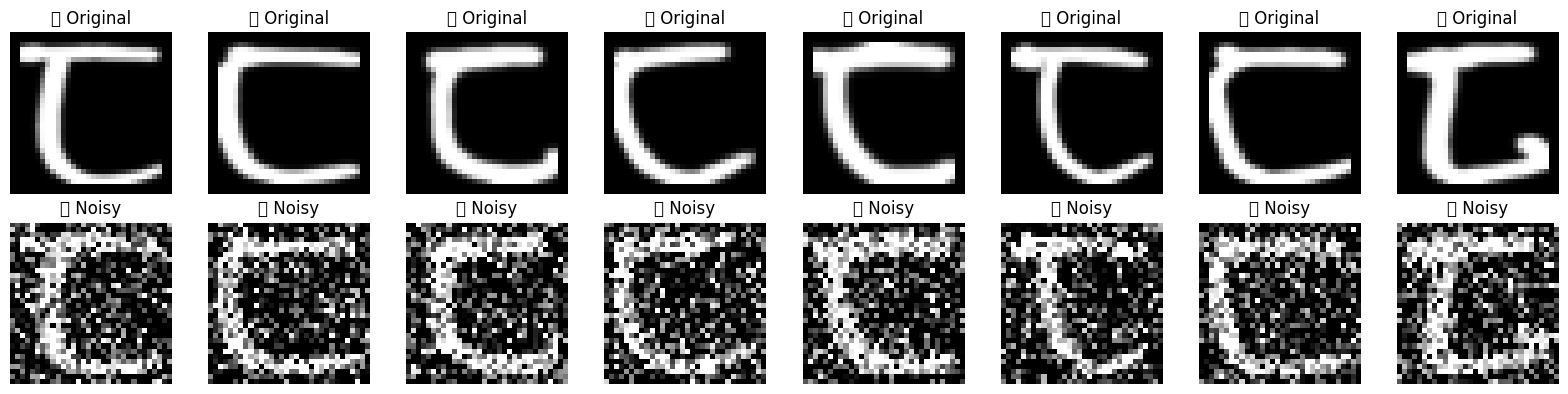

In [9]:
def display_digit_8(original, noisy, num_images=8):
    plt.figure(figsize=(16, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i].reshape(img_size, img_size), cmap="gray")
        plt.title("८ Original")
        plt.axis("off")

        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(noisy[i].reshape(img_size, img_size), cmap="gray")
        plt.title("८ Noisy")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

display_digit_8(x_digit_8, x_digit_8_noisy)

Step 2: Build the Convolutional Denoising Autoencoder Model:

 Build Encoder

In [10]:
def build_encoder(input_shape=(32, 32, 1)):
    input_img = Input(shape=input_shape, name="input")
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name="encoded")(x)
    return input_img, encoded

Build Decoder

In [11]:
def build_decoder(encoded_input):
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded_input)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name="decoded")(x)
    return decoded

 Build Autoencoder Model

In [12]:
def build_autoencoder():
    input_img, encoded_output = build_encoder(input_shape=(32, 32, 1))
    decoded_output = build_decoder(encoded_output)
    autoencoder = Model(inputs=input_img, outputs=decoded_output, name="autoencoder")
    autoencoder.compile(optimizer=Adam(), loss='binary_crossentropy')
    return autoencoder

Create and Summarize the Model

In [17]:
autoencoder = build_autoencoder()
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoded (MaxPooling2D)               │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoded (Conv2D)                     │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Step 3: Train the Autoencoder

In [22]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the images to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the images to include the channel dimension (28, 28, 1)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Function to add noise to images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)  # Ensure values are in [0, 1]

# Create noisy images
x_train_noisy_high = add_noise(x_train)
x_test_noisy_high = add_noise(x_test)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.2304 - val_loss: 0.1130
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1121 - val_loss: 0.1049
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1051 - val_loss: 0.1021
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1018 - val_loss: 0.0996
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0999 - val_loss: 0.0981
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0986 - val_loss: 0.0976
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0980 - val_loss: 0.0970
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0972 - val_loss: 0.0963
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0965 - val_loss: 0.0956
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0959 - val_loss: 0.0950


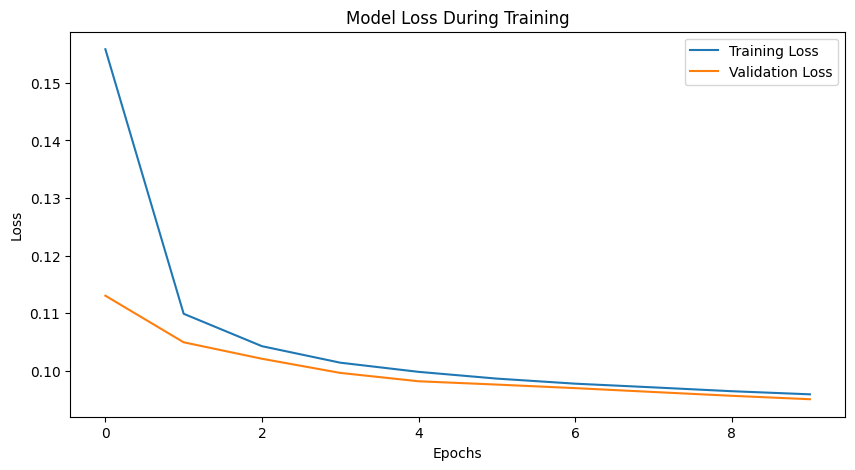

In [21]:
# Build the autoencoder from previous steps
autoencoder = build_autoencoder()

# Train with noisy input and clean target
history = autoencoder.fit(
    x_train_noisy_high,  # Noisy images as input
    x_train,             # Clean images as target
    epochs=10,           # Number of epochs
    batch_size=128,      # Batch size
    shuffle=True,        # Shuffle the training data
    validation_data=(x_test_noisy_high, x_test)  # Validation data
)

# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Step 4: Evaluate the Autoencoder

In [23]:
# Predict the denoised images from noisy test images
denoised_images = autoencoder.predict(x_test_noisy_high)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


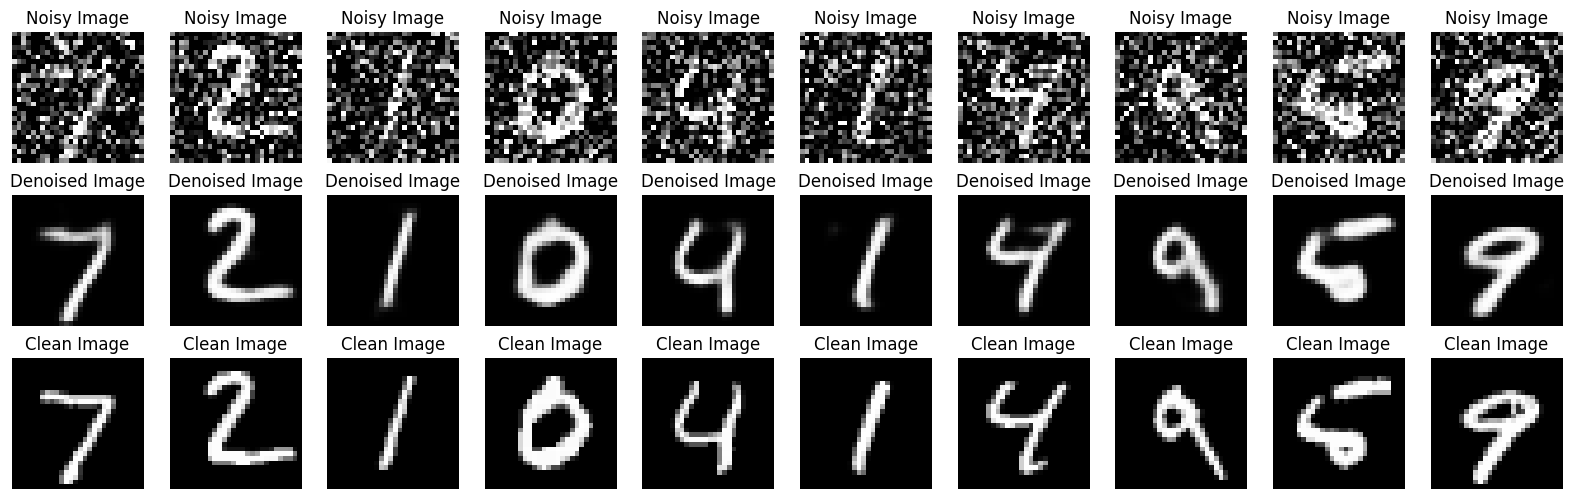

In [30]:
# Function to display images
def plot_images(noisy_images, denoised_images, clean_images, n=10):
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Plot noisy images
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_images[i].reshape(28, 28), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        # Plot denoised images
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        # Plot clean images
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_images[i].reshape(28, 28), cmap='gray')
        plt.title("Clean Image")
        plt.axis('off')

    plt.show()

# Display the first 10 images
plot_images(x_test_noisy_high, denoised_images, x_test, n=10)

4. Build a Denoising Convolutional Autoencoder

Dataset Preparation and Preprocessing

In [81]:
# Set your correct dataset path
dataset_path = '/content/Devnagari/DevanagariHandwrittenDigitDataset'

img_width, img_height = 32, 32

def load_images_from_folder(folder_path):
    images, labels = [], []
    class_names = sorted(os.listdir(folder_path))  # Assuming folders are named '0', '1', ...
    class_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue
        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            try:
                img = Image.open(file_path).convert('L')  # Grayscale
                img = img.resize((img_width, img_height))
                img_array = np.array(img)
                images.append(img_array)
                labels.append(class_map[class_name])
            except Exception as e:
                print(f"Skipping {file_path}: {e}")
                continue

    return np.array(images), np.array(labels)


In [77]:
# Load and preprocess
images, labels = load_images_from_folder(dataset_path)
print(f"Total images loaded: {len(images)}")


Skipping /content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_8: [Errno 21] Is a directory: '/content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_8'
Skipping /content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_4: [Errno 21] Is a directory: '/content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_4'
Skipping /content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_7: [Errno 21] Is a directory: '/content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_7'
Skipping /content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_9: [Errno 21] Is a directory: '/content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_9'
Skipping /content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_5: [Errno 21] Is a directory: '/content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_5'
Skipping /content/Devnagari/DevanagariHandwrittenDigitDataset/Test/digit_0: [Errno 21] Is a directory: '/content/Devnagari/DevanagariHandwrittenD

In [78]:
# Normalize and reshape
images = images.astype('float32') / 255.0
images = np.reshape(images, (len(images), 32, 32, 1))

In [79]:
# Train-validation split
train_dir = '/content/drive/MyDrive/Devanagari/Train'

Add noise

In [94]:
# Check the shape of the data
print("x_train_data shape:", x_train_data.shape)
print("y_train_data shape:", y_train_data.shape)

# Split the data
x_train, x_val, y_train, y_val = train_test_split(x_train_data, y_train_data, test_size=0.2, random_state=42)



x_train_data shape: (1000, 28, 28, 1)
y_train_data shape: (1000,)


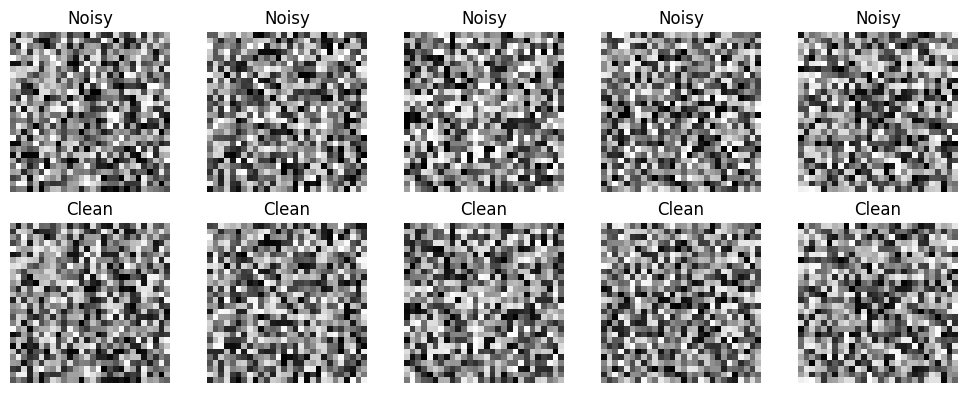

In [97]:
# Visualize
def show_sample_images(clean, noisy, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(noisy[i].reshape(28, 28), cmap="gray")  # Adjust the reshape dimensions
        plt.title("Noisy")
        plt.axis("off")
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(clean[i].reshape(28, 28), cmap="gray")  # Adjust the reshape dimensions
        plt.title("Clean")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function to visualize
show_sample_images(x_train, x_train_noisy)

2. Build the Denoising Convolutional Autoencoder


In [121]:
def build_denoising_autoencoder(input_shape):
    # Encoder
    input_img = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder model
    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder




3. Train the Denoising Autoencoder:



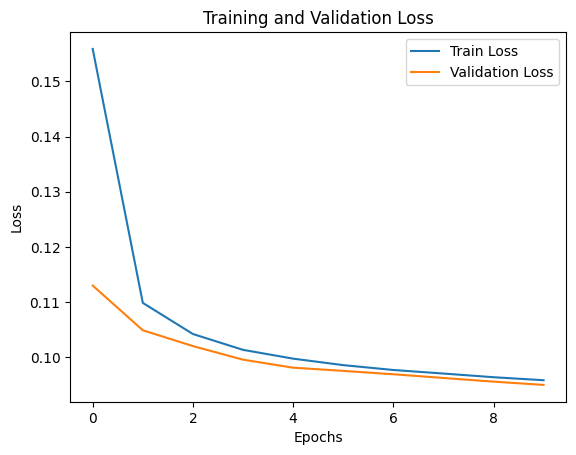

In [127]:
# Train the model with noisy images as inputs and original images as targets
train_dir = '/content/drive/MyDrive/Devanagari/Train'

# Plot the loss curves
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


4. Evaluate and Visualize the Results:



300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


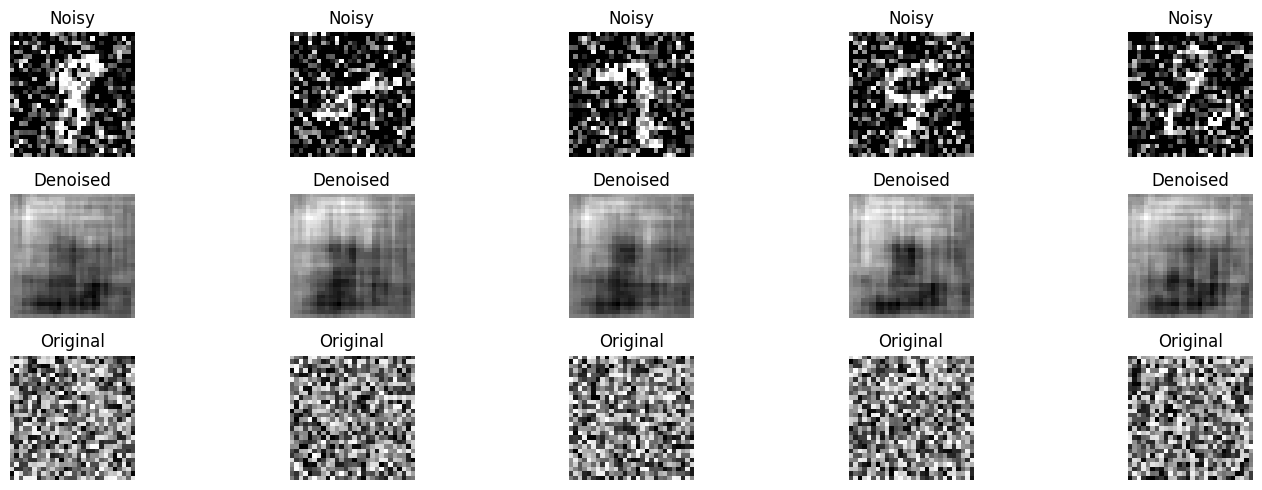

In [144]:
# Evaluate the model on noisy validation images
denoised_images = autoencoder.predict(x_val_noisy)  # Use x_val_noisy instead of X_val_noisy

# Visualize noisy, denoised, and original images
n = 5  # Number of images to display
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
for i in range(n):
    # Noisy Image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_val_noisy[i].squeeze(), cmap='gray')  # Use x_val_noisy
    plt.title("Noisy")
    ax.axis('off')

    # Denoised Image
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(denoised_images[i].squeeze(), cmap='gray')
    plt.title("Denoised")
    ax.axis('off')

    # Original Image
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(x_val[i].squeeze(), cmap='gray')  # Use x_val
    plt.title("Original")
    ax.axis('off')

plt.tight_layout()
plt.show()